# Plot intervalli di confidenza

Notebook per "plottare" gli intervalli di confidenza dei test effettuati.
Vengono letti tutti i risultati delle evaluations presenti su disco e raggruppati in base ai parametri di input.
> NB:
> - i test sono stati effettuati con valori random per il seed per generare una base di campioni da confrontare.
> - per problemi legati al tempo di esecuzione dei test il numero di campioni delle popolazioni sono ridotti per cui è stato calcolato lo standard error sui singoli campioni a disposizione per ogni impostazione ed utilizzata la statistica "t" al posto della distribuzione normale ("z-score")

## Caricamento dei dati disco

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
curdir = Path('./statoutput')
stat = pd.DataFrame()
for f in curdir.glob('eval*'):
    df = pd.read_pickle(f)
    actfunc = df.get('params.action_activation', ['sigmoid'])
    df['category'] = f"B{df.at[0, 'params.batch']}-E{df.at[0, 'params.epochs']}-H{df.at[0, 'params.hidden_output_dim']}\
-LR{df.at[0, 'params.learning_rate']}-eps{df.at[0, 'params.tolerance']}-ACT-{actfunc[0]}"
    stat = pd.concat([stat, df])
print(stat.head())
print(stat.shape)

   action_accuracy  action_perplexity  attribute_accuracy  \
0         0.850287           5.733896            0.791629   
0         0.848249           3.554360            0.759871   
0         0.845655           4.842728            0.771190   
0         0.848805           6.511304            0.785019   
0         0.854178           2.596618            0.764734   

                                    confusion_matrix  params.batch  \
0  [[733.0, 46.0, 6.0, 4.0, 15.0], [41.0, 1040.0,...            12   
0  [[749.0, 43.0, 8.0, 5.0, 14.0], [19.0, 1091.0,...            12   
0  [[742.0, 45.0, 13.0, 13.0, 15.0], [29.0, 1086....            12   
0  [[735.0, 42.0, 10.0, 3.0, 13.0], [38.0, 1048.0...            12   
0  [[750.0, 49.0, 12.0, 3.0, 16.0], [25.0, 1089.0...            12   

   params.epochs  params.hidden_output_dim  params.seed  params.learning_rate  \
0              6                       768      1264540               0.00005   
0              6                       256      20

## Calcolo statistiche

In [8]:
stat_mean = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).mean().add_suffix('_mean')
stat_std = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).std().add_suffix('_std')
stat_var = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).var().add_suffix('_var')
stat_stderr = stat.drop('params.seed', 1).groupby(['params.epochs', 'params.batch', 'params.hidden_output_dim', 'params.learning_rate', 'params.tolerance']).sem().add_suffix('_std_err')

stat_group = stat.drop(columns = ['params.batch',
                                  'params.epochs', 
                                  'params.hidden_output_dim', 
                                  'params.seed', 
                                  'params.learning_rate', 
                                  'params.tolerance'],
                       axis = 1).groupby('category')
#stat_df = stat_group.merge(stat_group.mean().add_suffix('_mean'))
#stat_df = stat_group.mean().add_suffix('_mean')
#stat_df1 = stat_group.std().add_suffix('_std')
df = stat_group.describe()
#for prop in df:
#    print(prop)
#print(df.index.values)
#df['class'] = str(list(df.index.values))
print(df)

                                          action_accuracy                      \
                                                    count      mean       std   
category                                                                        
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid            10.0  0.845340  0.003065   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax              1.0  0.844729       NaN   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid             10.0  0.848064  0.004033   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid             10.0  0.846322  0.001900   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax             10.0  0.849231  0.002371   

                                                                         \
                                                min       25%       50%   
category                                                                  
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid  0.840467  0.844543  0.844821   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax   0.844729

# Standard error (per calcolo intervallo di confidenza)

In [9]:
t_dist_2_tailed_95 = [np.nan, 
                      12.71, 4.3, 3.18, 2.78, 2.57, 2.45, 2.36, 2.31, 2.26, 2.23, 
                      2.20, 2.18, 2.16, 2.14, 2.13, 2.12, 2.11, 2.10, 2.09, 2.09, 
                      2.08, 2.07, 2.07, 2.06, 2.06, 2.06, 2.05, 2.05, 2.05, 2.04]
df['degree_of_freedom'] = df[('action_accuracy', 'count')] - 1
df['t_N_minus_1'] = df['degree_of_freedom'].apply(lambda x: t_dist_2_tailed_95[int(x)])

df[('action_accuracy', 'stderr')] = df[('action_accuracy', 'std')] / np.sqrt(df[('action_accuracy', 'count')])
df[('action_accuracy', 'ci')] = df['t_N_minus_1'] * df[('action_accuracy', 'stderr')]
df[('action_accuracy', 'lo_bond_ci')] = df[('action_accuracy', 'mean')] - df['t_N_minus_1'] * df[('action_accuracy', 'stderr')]
df[('action_accuracy', 'up_bond_ci')] = df[('action_accuracy', 'mean')] + df['t_N_minus_1'] * df[('action_accuracy', 'stderr')]

df[('action_perplexity', 'stderr')] = df[('action_perplexity', 'std')] / np.sqrt(df[('action_perplexity', 'count')])
df[('action_perplexity', 'ci')] = df['t_N_minus_1'] * df[('action_perplexity', 'stderr')]
df[('action_perplexity', 'lo_bond_ci')] = df[('action_perplexity', 'mean')] - df['t_N_minus_1'] * df[('action_perplexity', 'stderr')]
df[('action_perplexity', 'up_bond_ci')] = df[('action_perplexity', 'mean')] + df['t_N_minus_1'] * df[('action_perplexity', 'stderr')]

df[('attribute_accuracy', 'stderr')] = df[('attribute_accuracy', 'std')] / np.sqrt(df[('attribute_accuracy', 'count')])
df[('attribute_accuracy', 'ci')] = df['t_N_minus_1'] * df[('attribute_accuracy', 'stderr')]
df[('attribute_accuracy', 'lo_bond_ci')] = df[('attribute_accuracy', 'mean')] - df['t_N_minus_1'] * df[('attribute_accuracy', 'stderr')]
df[('attribute_accuracy', 'up_bond_ci')] = df[('attribute_accuracy', 'mean')] + df['t_N_minus_1'] * df[('attribute_accuracy', 'stderr')]

df

action_accuracy                      \
                                                    count      mean       std   
category                                                                        
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid            10.0  0.845340  0.003065   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax              1.0  0.844729       NaN   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid             10.0  0.848064  0.004033   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid             10.0  0.846322  0.001900   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax             10.0  0.849231  0.002371   

                                                                         \
                                                min       25%       50%   
category                                                                  
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid  0.840467  0.844543  0.844821   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax   0.844729  0.844729  0.844729   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid   0.842876  0.845377  0.847878   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid   0.843617  0.845006  0.845933   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax   0.845840  0.847878  0.848990   

                                                               \
                                                75%       max   
category                                                        
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid  0.846767  0.851399   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax   0.844729  0.844729   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid   0.848805  0.855290   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid   0.847786  0.849361   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax   0.851121  0.852511   

                                          action_perplexity            ...  \
                                                      count      mean  ...   
category                                                               ...   
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid              10.0  4.635046  ...   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax                1.0  4.526007  ...   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid               10.0  3.285735  ...   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid               10.0  3.664891  ...   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax               10.0  6.199974  ...   

                                          action_accuracy             \
                                               lo_bond_ci up_bond_ci   
category                                                               
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid        0.843150   0.847530   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax              NaN        NaN   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid         0.845181   0.850946   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid         0.844964   0.847680   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax         0.847536   0.850926   

                                          action_perplexity            \
                                                     stderr        ci   
category                                                                
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid          0.157732  0.356474   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax                NaN       NaN   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid           0.111583  0.252177   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid           0.098426  0.222443   
B12-E6-H768-LR5e-05-eps1e-08-ACT-softmax           0.139110  0.314389   

                                                                 \
                                          lo_bond_ci up_bond_ci   
category                                                          
B12-E10-H256-LR5e-05-eps1e-08-ACT-sigmoid   4.278571   4.991520   
B12-E2-H768-LR5e-05-eps1e-08-ACT-softmax         NaN        NaN   
B12-E6-H256-LR5e-05-eps1e-08-ACT-sigmoid    3.033558   3.537912   
B12-E6-H768-LR5e-05-eps1e-08-ACT-sigmoid    3.442448   3.887334   
B12-E6-H768-LR5

## Controllo di aver calcolato correttamente lo stderr

In [10]:
print(stat_stderr)

                                                                                           action_accuracy_std_err  \
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance                            
2             12           768                      0.00005              1.000000e-08                          NaN   
6             12           256                      0.00005              1.000000e-08                     0.001275   
                           768                      0.00005              1.000000e-08                     0.000574   
10            12           256                      0.00005              1.000000e-08                     0.000969   

                                                                                           action_perplexity_std_err  \
params.epochs params.batch params.hidden_output_dim params.learning_rate params.tolerance                              
2             12           768                     

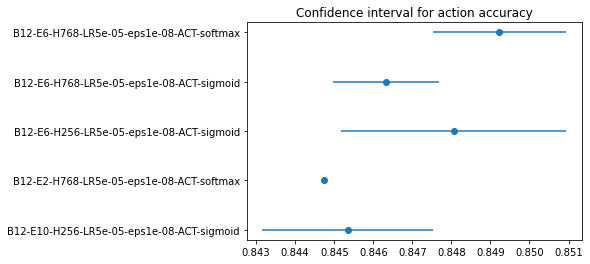

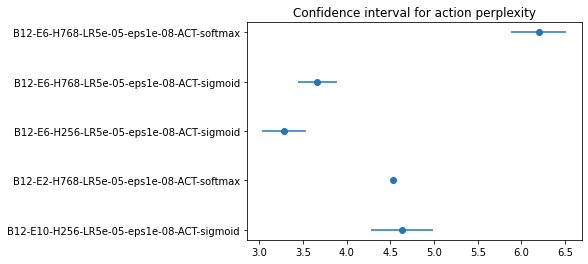

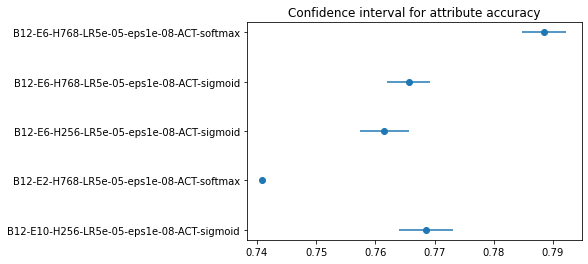

In [11]:
import matplotlib.pyplot as plt

#plt.errorbar(df.index, ('action_accuracy', 'mean'), yerr=('action_accuracy', 'ci'), data=df)
plt.errorbar(x = df[('action_accuracy', 'mean')], 
             y = df.index, 
             xerr = df[('action_accuracy', 'ci')], 
             fmt = 'o')
plt.title('Confidence interval for action accuracy')
plt.show()

plt.errorbar(x = df[('action_perplexity', 'mean')], 
             y = df.index, 
             xerr = df[('action_perplexity', 'ci')], 
             fmt = 'o')
plt.title('Confidence interval for action perplexity')
plt.show()

plt.errorbar(x = df[('attribute_accuracy', 'mean')], 
             y = df.index, 
             xerr = df[('attribute_accuracy', 'ci')], 
             fmt = 'o')
plt.title('Confidence interval for attribute accuracy')
plt.show()
#df[[('action_accuracy', 'mean'), ('attribute_accuracy', 'mean')]].boxplot(vert=False)
#stat.groupby('category').boxplot(vert=False, column='action_accuracy')

# Esempi visualizzazione errore

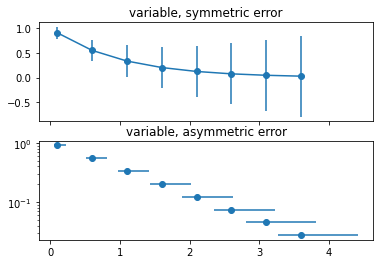

<AxesSubplot:title={'center':'attribute_accuracy'}, xlabel='category'>

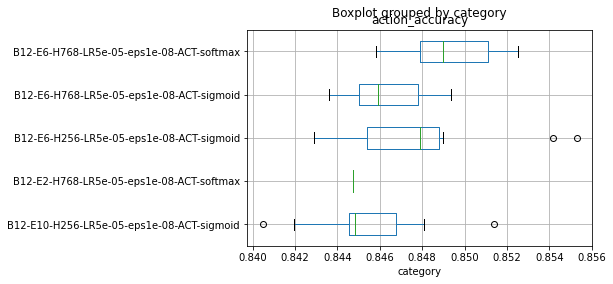

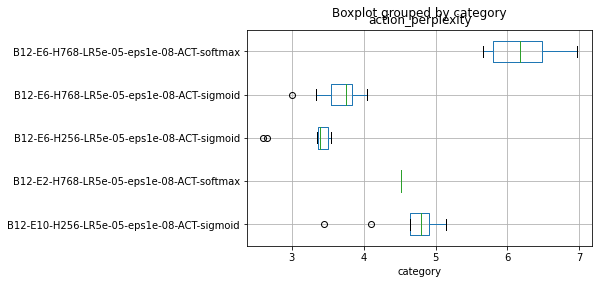

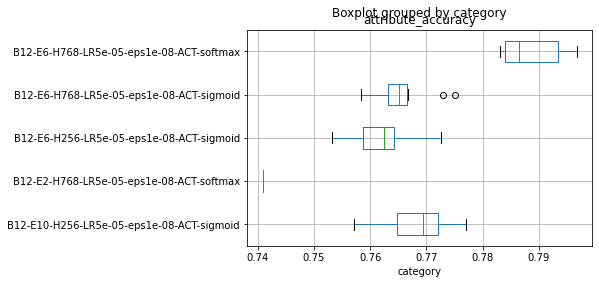

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()

stat.boxplot(column='action_accuracy', by='category', vert=False)
stat.boxplot(column='action_perplexity', by='category', vert=False)
stat.boxplot(column='attribute_accuracy', by='category', vert=False)
